<a href="https://colab.research.google.com/github/tumpudikarthikeya/Cafe/blob/main/Curvetopia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from shapely.geometry import Polygon
from shapely.affinity import rotate
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
import matplotlib.pyplot as plt



def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs
def smooth_curve(XY, s=0.1):
    tck, u = splprep([XY[:, 0], XY[:, 1]], s=s)
    unew = np.linspace(0, 1, 100)
    smooth_curve = np.column_stack(splev(unew, tck))
    return smooth_curve

def detect_shapes(XY):
    # Use DBSCAN to cluster points and detect potential shapes
    clustering = DBSCAN(eps=5, min_samples=3).fit(XY)
    labels = clustering.labels_
    shapes = []
    for label in np.unique(labels):
        if label != -1:  # Ignore noise points
            shape_points = XY[labels == label]
            shapes.append(shape_points)
    return shapes

def regularize_shape(shape):
    hull = ConvexHull(shape)
    hull_points = shape[hull.vertices]

    hull_points_rolled = np.roll(hull_points, 1, axis=0)
    perimeter = np.sum(np.sqrt(np.sum((hull_points - hull_points_rolled)**2, axis=1)))

    area = hull.area
    circularity = 4 * np.pi * area / (perimeter ** 2)

    if circularity > 0.9:  # Likely a circle
        center = np.mean(hull_points, axis=0)
        radius = np.mean(np.linalg.norm(hull_points - center, axis=1))
        theta = np.linspace(0, 2*np.pi, 100)
        regular_shape = np.column_stack([radius * np.cos(theta) + center[0],
                                         radius * np.sin(theta) + center[1]])
    elif len(hull_points) == 4:  # Likely a rectangle
        pca = PCA(n_components=2)
        pca.fit(hull_points)
        aligned_points = pca.transform(hull_points)
        min_coords = np.min(aligned_points, axis=0)
        max_coords = np.max(aligned_points, axis=0)
        regular_shape = np.array([[min_coords[0], min_coords[1]],
                                  [max_coords[0], min_coords[1]],
                                  [max_coords[0], max_coords[1]],
                                  [min_coords[0], max_coords[1]]])
        regular_shape = pca.inverse_transform(regular_shape)
    else:  # General polygon
        regular_shape = hull_points

    return regular_shape

def detect_symmetry(shape):
    poly = Polygon(shape)

    def asymmetry(angle):
        rotated = rotate(poly, angle)
        return abs(rotated.symmetric_difference(poly).area)

    result = minimize(asymmetry, 0, method='powell')
    symmetry_angle = result.x[0]

    is_symmetric = result.fun < 0.1 * poly.area

    return is_symmetric, symmetry_angle

def auto_complete(shape, is_symmetric, symmetry_angle):
    if not is_symmetric:
        return shape

    poly = Polygon(shape)
    rotated = rotate(poly, 2*symmetry_angle)
    completed = poly.union(rotated)

    if completed.geom_type == 'Polygon':
        return np.array(completed.exterior.coords)
    else:  # MultiPolygon
        return np.array(completed.geoms[0].exterior.coords)

def process_doodle(path_XYs):
    processed_paths = []
    for XYs in path_XYs:
        processed_XYs = []
        for XY in XYs:
            smooth_XY = smooth_curve(XY)
            shapes = detect_shapes(smooth_XY)
            for shape in shapes:
                regular_shape = regularize_shape(shape)
                is_symmetric, symmetry_angle = detect_symmetry(regular_shape)
                completed_shape = auto_complete(regular_shape, is_symmetric, symmetry_angle)
                processed_XYs.append(completed_shape)
        processed_paths.append(processed_XYs)
    return processed_paths
def plot(paths_XYs, title, ax, smooth=False):
    colours = ['red', 'green', 'blue', 'yellow', 'purple']  # Define some colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            if smooth:
                XY = smooth_path(XY)
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


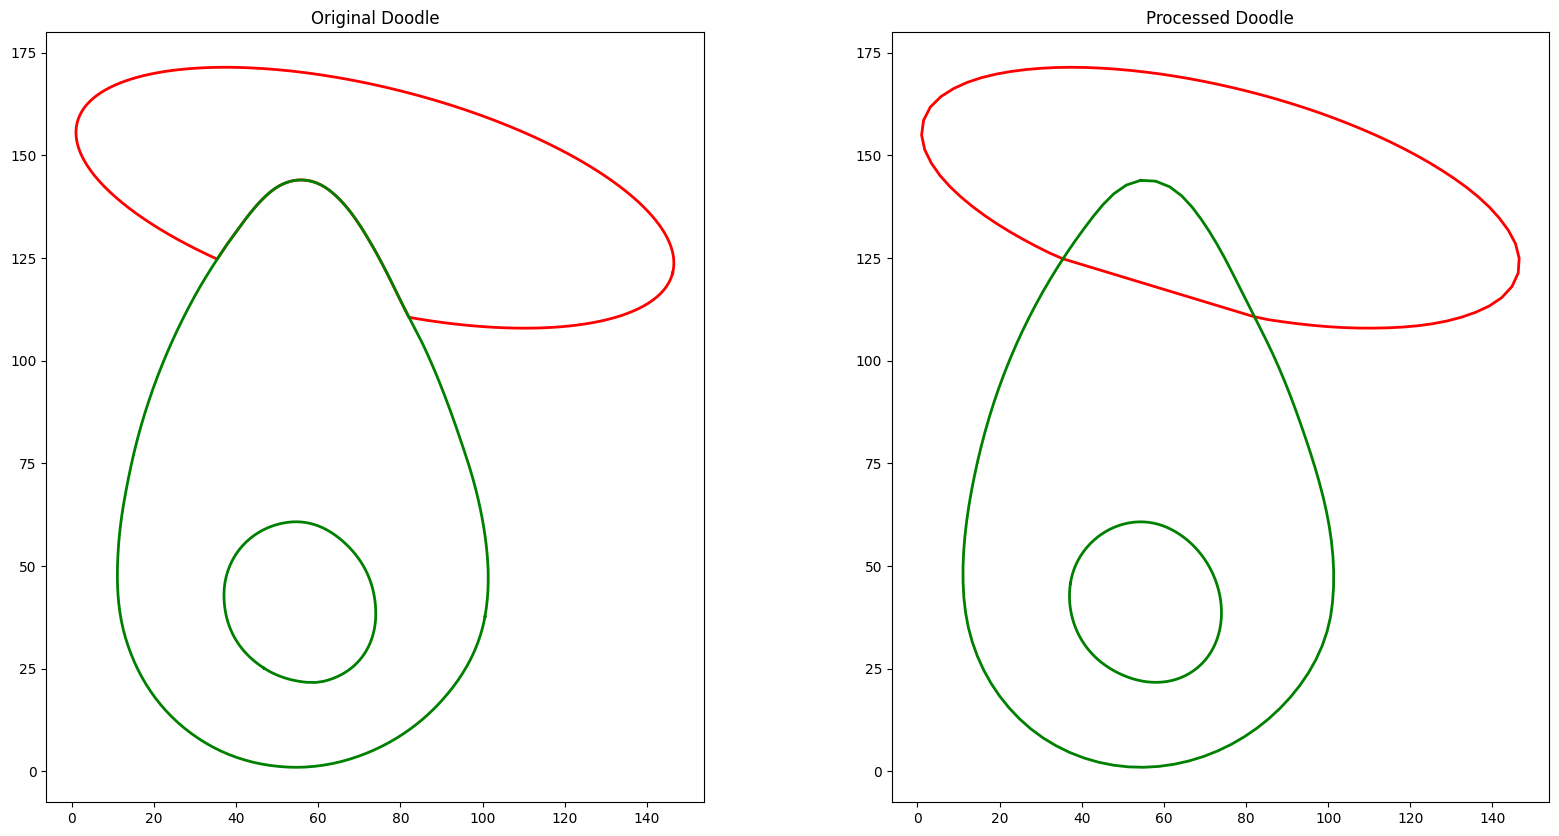

In [10]:
csv_path = '/content/drive/MyDrive/Adobe/occlusion1.csv'  # Update with your file path
path_XYs = read_csv_(csv_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plot(path_XYs, 'Original Doodle', ax1)

processed_paths = process_doodle(path_XYs)
plot(processed_paths, 'Processed Doodle', ax2)

plt.show()